In [1]:
from tqdm import tqdm
import random
import sys
sys.path.append("../")
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from cachingalgo.full_observation.single_cache import LFULite, LFU
from cachingalgo.request_generation.continuous import szipf, netflix, youtube

$Cache Hit = \frac{\sum_{i=1}^{N}hits_{i}}{\sum_{i=1}^{N}hits_{i} + \sum_{i=1}^{N}miss_{i}}$
where, N is the number of caches used in the algorithm $\newline$
$Stretch = \frac{\sum_{i=1}^{R}hops\_walked_{i}}{\sum_{i=1}^{R}total\_hops_{i}}$ where, R is the total no. of requests $\newline$
$Diversity = \frac{len(\cup_{n=1}^{N}C_{n})}{\sum_{n=1}^{N}len(C_{n})}$ which varies in the range $[\frac{1}{N},1]$

## Simulations of Tandem Model with LFU and LFULite

In [18]:
def lfu_tandem_sim(cache_size = 0, req = None, prob = None, overlap = False):
    L = len(prob)
    reg = 0
    cache_size = cache_size # Each cache is of size cache_size
    hits = 0
    hops = 0
    totalreq = req.shape[0]
    
    regret = np.zeros((totalreq,))
    if overlap: 
        diversity = np.zeros((totalreq,))
    currcache = random.sample(range(1,L),2*cache_size)
    optcache = np.argsort(prob)[::-1][:2*cache_size]

    # Cache 1
    alg1 = LFU(L=L, cache_size=cache_size)
    currcache1 = currcache[:cache_size]
    optcache1 = optcache[:cache_size]
    counters1 = np.zeros((totalreq,))
    regret1 = np.zeros((totalreq,))
    hits1 = 0
    reg1 = 0

    # Cache 2
    alg2 = LFU(L=L, cache_size=cache_size)
    currcache2 = currcache[cache_size:]
    optcache2 = optcache[cache_size:]
    counters2 = np.zeros((totalreq,))
    regret2 = np.zeros((totalreq,))
    hits2 = 0
    reg2 = 0
    
    # No. of requests going through cache 2
    c2req = 0
    for i in tqdm(range(totalreq)):
        request = req[i]

        # Complete
        if request in currcache1 or request in currcache2:
            rhs = 1
            hits += 1
        else:
            rhs = 0

        if request in optcache1 or request in optcache2:
            lhs = 1  
        else:
            lhs = 0

        # Cache 1
        lhs1 = 1 if request in optcache1 else 0
        if request in currcache1:
            rhs1 = 1
            hits1 += 1
        else:
            rhs1 = 0
            c2req += 1

        # Cache 2
        lhs2 = 1 if request in optcache2 else 0
        if request in currcache2:
            rhs2 = 1
            hits2 += 1
        else:
            rhs2 = 0
        
        # request hop
        if request in currcache1:
            hop = 1
        elif request in currcache2:
            hop = 2
        else:
            hop = 3
        
        # Diversity
        if overlap: 
            diversity[i] = len(set(currcache1).union(currcache2))/(2*cache_size)
        
        alg1.update(request)
        currcache1 = alg1.currcache()

        if request not in currcache1:
            alg2.update(request)
            
            # whether cache should have duplicate items or not
            if overlap:
                currcache2 = alg2.currcache()
            else:
                currcache2 = alg2.currcache(exclude = currcache1)

        reg += (lhs-rhs)
        regret[i] = reg

        reg1 += (lhs1 - rhs1)
        regret1[i] = reg1
        counters1[i] = alg1.counters_used()

        reg2 += (lhs2 - rhs2)
        regret2[i] = reg2
        counters2[i] = alg2.counters_used()
        
        hops += hop    
    
    Cachehit = (hits1 + hits2)/(2*totalreq)
    Stretch = hops/(3*totalreq)
    
    params = {'counter_all':[counters1, counters2], 'regret_all':[regret, regret1, regret2], 
            'currcache_all':[currcache1, currcache2], 'hit_all':[hits, hits1, hits2], 
            'optcache':optcache, 'cachehit':Cachehit, 'stretch':Stretch, 'c2req':c2req}
    if overlap:
        params['diversity'] = diversity

    return params

def lfulite_tandem_sim(cache_size = 0, req = None, prob = None, overlap = False):
    L = len(prob)
    reg = 0
    cache_size = cache_size # Each cache is of size top
    hits = 0
    hops = 0
    totalreq = req.shape[0]

    regret = np.zeros((totalreq,))
    if overlap: 
        diversity = np.zeros((totalreq,))
    currcache = random.sample(range(1,L),2*cache_size)
    optcache = np.argsort(prob)[::-1][:2*cache_size]

    # Cache 1
    algLL1 = LFULite(L=L, cache_size=cache_size)
    currcache1 = currcache[:cache_size]
    optcache1 = optcache[:cache_size]
    counters1 = np.zeros((totalreq,))
    regret1 = np.zeros((totalreq,))
    hits1 = 0
    reg1 = 0

    # Cache 2
    algLL2 = LFULite(L=L, cache_size=cache_size)
    currcache2 = currcache[cache_size:]
    optcache2 = optcache[cache_size:]
    counters2 = np.zeros((totalreq,))
    regret2 = np.zeros((totalreq,))
    hits2 = 0
    reg2 = 0
    
    # No. of requests going through the cache 2
    c2req = 0
    
    for i in tqdm(range(totalreq)):
        request = req[i]

        # Complete
        if request in currcache1 or request in currcache2:
            rhs = 1
            hits += 1
        else:
            rhs = 0

        if request in optcache1 or request in optcache2:
            lhs = 1  
        else:
            lhs = 0

        # Cache 1
        lhs1 = 1 if request in optcache1 else 0
        if request in currcache1:
            rhs1 = 1
            hits1 += 1
        else:
            rhs1 = 0
            c2req += 1
            
        # Cache 2
        lhs2 = 1 if request in optcache2 else 0
        if request in currcache2:
            rhs2 = 1
            hits2 += 1
        else:
            rhs2 = 0
        
        # request hop
        if request in currcache1:
            hop = 1
        elif request in currcache2:
            hop = 2
        else:
            hop = 3

        # Diversity
        if overlap: 
            diversity[i] = len(set(currcache1).union(currcache2))/(2*cache_size)
            
        algLL1.update(request, i)
        currcache1 = algLL1.currcache(i)

        if request not in currcache1:
            algLL2.update(request, i)
            
             # whether cache should have duplicate items or not
            if overlap:
                currcache2 = algLL2.currcache(i)
            else:
                currcache2 = algLL2.currcache(i, exclude = currcache1)

        reg += (lhs-rhs)
        regret[i] = reg

        reg1 += (lhs1 - rhs1)
        regret1[i] = reg1
        counters1[i] = algLL1.counters_used()

        reg2 += (lhs2 - rhs2)
        regret2[i] = reg2
        counters2[i] = algLL2.counters_used()
        
        hops += hop    
    
    Cachehit = (hits1 + hits2)/(2*totalreq)
    Stretch = hops/(3*totalreq)
    
    params = {'counter_all':[counters1, counters2], 'regret_all':[regret, regret1, regret2], 
            'currcache_all':[currcache1, currcache2], 'hit_all':[hits, hits1, hits2], 
            'optcache':optcache, 'cachehit':Cachehit, 'stretch':Stretch, 'c2req':c2req}
    if overlap:
        params['diversity'] = diversity

    return params

def plotregcount(totalreq, Regret = None, Counter = None, regname = '', countname = ''):
    x = [i for i in range(totalreq)]
    plt.plot(x, list(Regret[0]), 'r', label = 'Combined', linewidth=2)
    plt.plot(x, list(Regret[1]), 'b', label = 'Cache 1', linewidth=2)
    plt.plot(x, list(Regret[2]), 'g', label = 'Cache 2', linewidth=2)
    plt.legend(loc = 'best')
    plt.xlabel('Time')
    plt.ylabel('Regret')
    if len(regname) != 0:
        plt.savefig(f"../plots/tandem_model/static_data/{regname}") 
    plt.show() 


    plt.plot(x, list(Counter[0]), 'b', label = 'Cache 1', linewidth=2)
    plt.plot(x, list(Counter[1]), 'g', label = 'Cache 2', linewidth=2)
    plt.legend(loc = 'best')
    plt.xlabel('Time')
    plt.ylabel('Counters')
    if len(countname) != 0:
        plt.savefig(f"../plots/tandem_model/static_data/{countname}")
    plt.show()


def printparam(totalreq, hits = None, stretch = None, cachehit = None, c2req = None):
    print("Hit Rate for Combined Cache = ", hits[0]/totalreq)
    print("Hit Rate for Cache1 = ", hits[1]/totalreq)
    print("Hit Rate for Cache2 = ", hits[2]/c2req)
    print("Cachehit = ",cachehit)
    print("Stretch = ",stretch)

### LFU

In [3]:
# Request Generation
szdata = szipf(count=1_00_000, a=1, L=1_61_085) # Static Zipf Data
netdata = netflix(count=1_00_000)
ytdata = youtube(count=1_00_000) # YouTube Data

#### Non-overlapping caches

Netflix Data

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:34<00:00, 648.05it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


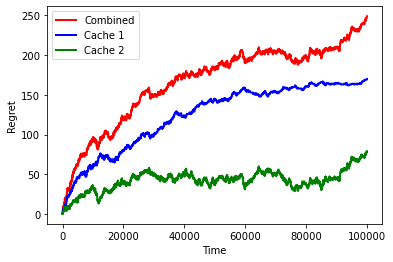

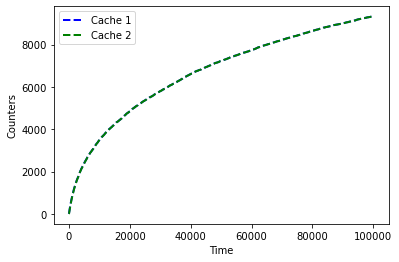

Hit Rate for Combined Cache =  0.03335
Hit Rate for Cache1 =  0.01803
Hit Rate for Cache2 =  0.015601291281811053
Cachehit =  0.016675
Stretch =  0.9828733333333334


In [4]:
totalreq = netdata['req'].shape[0]

params1 = lfu_tandem_sim(cache_size = 10, req = netdata['req'], prob = netdata['prob'])
plotregcount(totalreq, Regret = params1['regret_all'], Counter = params1['counter_all'], regname="nnovnetreglfu.eps")
printparam(totalreq, hits = params1['hit_all'], stretch = params1['stretch'], cachehit = params1['cachehit'], c2req= params1['c2req'] )

YouTube Data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


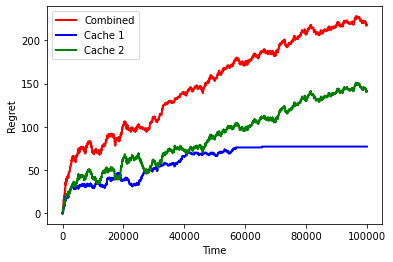

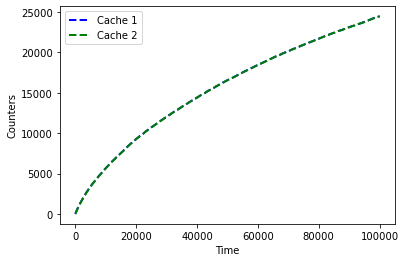

Hit Rate for Combined Cache =  0.04904
Hit Rate for Cache1 =  0.03113
Hit Rate for Cache2 =  0.018485452124640044
Cachehit =  0.02452
Stretch =  0.9732766666666667


In [5]:
totalreq = ytdata['req'].shape[0]

params2 = lfu_tandem_sim(cache_size = 10, req = ytdata['req'], prob = ytdata['prob'])
plotregcount(totalreq, Regret = params2['regret_all'], Counter = params2['counter_all'], regname="nnovytreglfu.eps")
printparam(totalreq, hits = params2['hit_all'], stretch = params2['stretch'], cachehit = params2['cachehit'],  c2req= params2['c2req'])

Static Zipf

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:30<00:00, 85.42it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


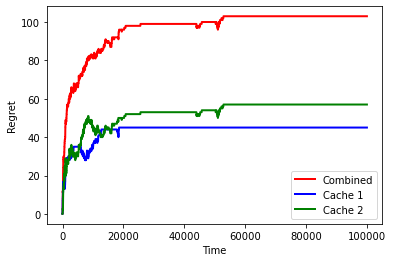

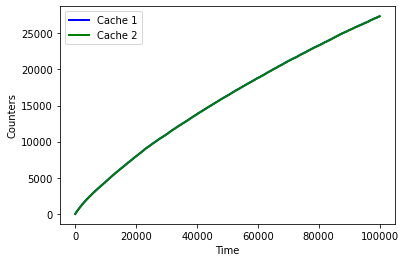

Hit Rate for Combined Cache =  0.28564
Hit Rate for Cache1 =  0.23311
Hit Rate for Cache2 =  0.06851047738267547
Cachehit =  0.142825
Stretch =  0.8270833333333333


In [4]:
totalreq = szdata['req'].shape[0]

params3 = lfu_tandem_sim(cache_size = 10, req = szdata['req'], prob = szdata['prob'])
plotregcount(totalreq, Regret = params3['regret_all'], Counter = params3['counter_all'], regname="nnovszreglfu.eps")
printparam(totalreq, hits = params3['hit_all'], stretch = params3['stretch'], cachehit = params3['cachehit'],  c2req= params3['c2req'])

#### Overlapping Caches

Netflix Data

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:41<00:00, 618.96it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


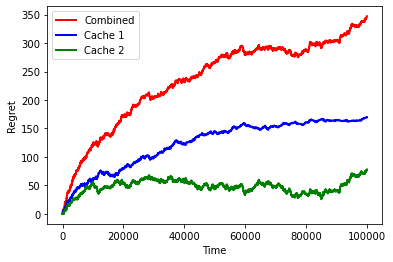

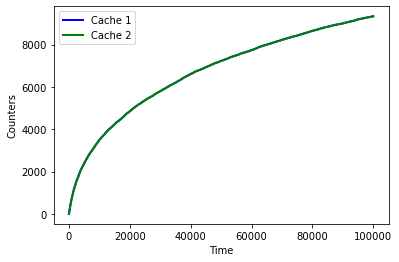

Hit Rate for Combined Cache =  0.03237
Hit Rate for Cache1 =  0.01803
Hit Rate for Cache2 =  0.01561147489230832
Cachehit =  0.01668
Stretch =  0.9832


In [6]:
totalreq = netdata['req'].shape[0]

params4 = lfu_tandem_sim(cache_size = 10, req = netdata['req'], prob = netdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params4['regret_all'], Counter = params4['counter_all'], regname="ovnetreglfu.eps")
printparam(totalreq, hits = params4['hit_all'], stretch = params4['stretch'], cachehit = params4['cachehit'], c2req=params4['c2req'])

YouTube Data

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [22:31<00:00, 73.99it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


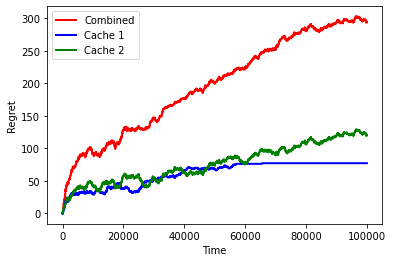

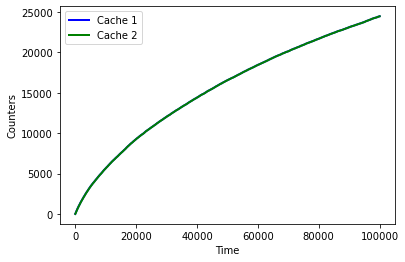

Hit Rate for Combined Cache =  0.04828
Hit Rate for Cache1 =  0.03113
Hit Rate for Cache2 =  0.01870219946948507
Cachehit =  0.024625
Stretch =  0.97353


In [7]:
totalreq = ytdata['req'].shape[0]

params5 = lfu_tandem_sim(cache_size = 10, req = ytdata['req'], prob = ytdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params5['regret_all'], Counter = params5['counter_all'], regname="ovytreglfu.eps")
printparam(totalreq, hits = params5['hit_all'], stretch = params5['stretch'], cachehit = params5['cachehit'],  c2req= params5['c2req'])

Static Zipf Data

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:22<00:00, 86.06it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


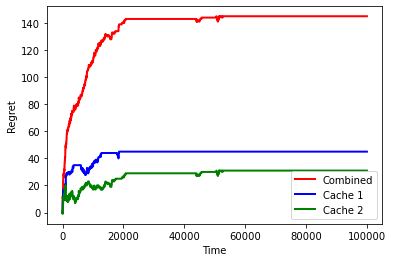

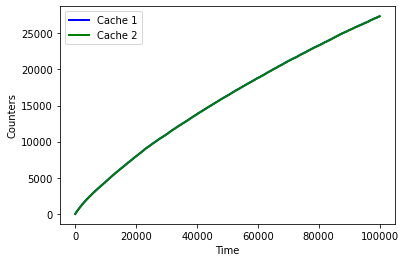

Hit Rate for Combined Cache =  0.28522
Hit Rate for Cache1 =  0.23311
Hit Rate for Cache2 =  0.06884950905605758
Cachehit =  0.142955
Stretch =  0.8272233333333333


In [10]:
totalreq = szdata['req'].shape[0]

params6 = lfu_tandem_sim(cache_size = 10, req = szdata['req'], prob = szdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params6['regret_all'], Counter = params6['counter_all'], regname="ovszreglfu.eps")
printparam(totalreq, hits = params6['hit_all'], stretch = params6['stretch'], cachehit = params6['cachehit'], c2req= params6['c2req'] )

Diversity Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


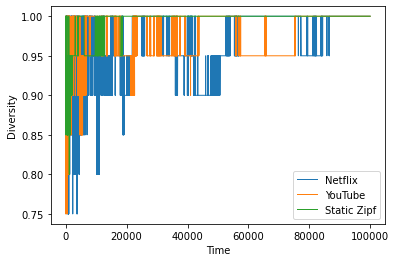

In [15]:
import matplotlib.pyplot as plt

x = list(range(totalreq))
plt.plot(x, params4['diversity'], label='Netflix', linewidth=1)
plt.plot(x, params5['diversity'], label='YouTube', linewidth=1)
plt.plot(x, params6['diversity'], label='Static Zipf', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Diversity')
plt.legend(loc="best")
plt.savefig("../plots/tandem_model/alldivlfu.eps")

### LFU-Lite

#### Non-Overlapping Caches

Netflix Data

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:17<00:00, 728.57it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


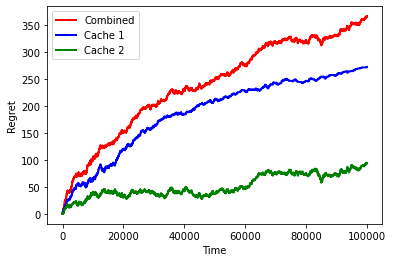

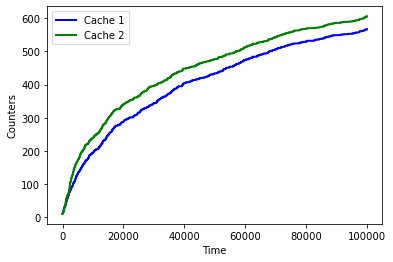

Hit Rate for Combined Cache =  0.03217
Hit Rate for Cache1 =  0.017
Hit Rate for Cache2 =  0.0154323499491353
Cachehit =  0.016085
Stretch =  0.98361


In [19]:
totalreq = netdata['req'].shape[0]

params7 = lfulite_tandem_sim(cache_size = 10, req = netdata['req'], prob = netdata['prob'])
plotregcount(totalreq, Regret = params7['regret_all'], Counter = params7['counter_all'], regname="nnovnetregllite.eps")
printparam(totalreq, hits = params7['hit_all'], stretch = params7['stretch'], cachehit = params7['cachehit'], c2req=params7['c2req'])

YouTube Data

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:43<00:00, 965.20it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


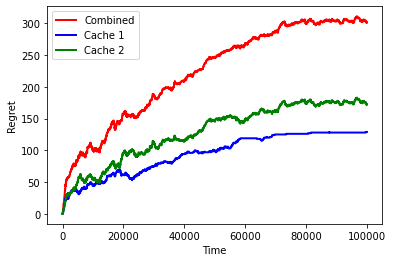

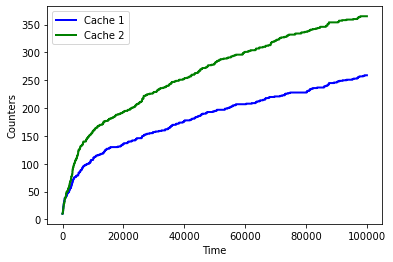

Hit Rate for Combined Cache =  0.04821
Hit Rate for Cache1 =  0.03061
Hit Rate for Cache2 =  0.01815574742879543
Cachehit =  0.024105
Stretch =  0.9737266666666666


In [20]:
totalreq = ytdata['req'].shape[0]

params8 = lfulite_tandem_sim(cache_size = 10, req = ytdata['req'], prob = ytdata['prob'])
plotregcount(totalreq, Regret = params8['regret_all'], Counter = params8['counter_all'], regname="nnovytregllite.eps")
printparam(totalreq, hits = params8['hit_all'], stretch = params8['stretch'], cachehit = params8['cachehit'],  c2req= params8['c2req'])

Static Zipf Data

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:47<00:00, 2117.50it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


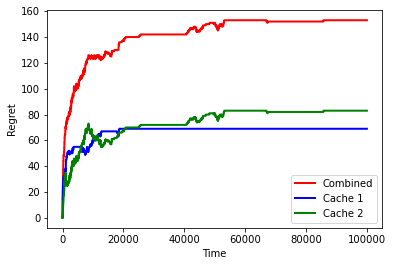

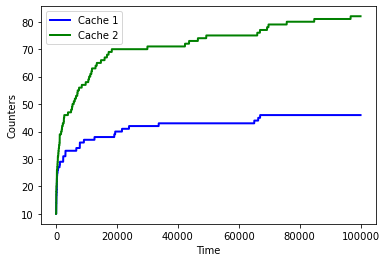

Hit Rate for Combined Cache =  0.28514
Hit Rate for Cache1 =  0.23287
Hit Rate for Cache2 =  0.06815011797218203
Cachehit =  0.142575
Stretch =  0.82733


In [21]:
totalreq = szdata['req'].shape[0]

params9 = lfulite_tandem_sim(cache_size = 10, req = szdata['req'], prob = szdata['prob'])
plotregcount(totalreq, Regret = params9['regret_all'], Counter = params9['counter_all'], regname="nnovszregllite.eps")
printparam(totalreq, hits = params9['hit_all'], stretch = params9['stretch'], cachehit = params9['cachehit'],  c2req= params9['c2req'])

#### Overlapping Caches

Netflix Data

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:21<00:00, 705.71it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


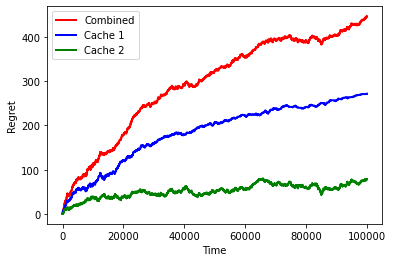

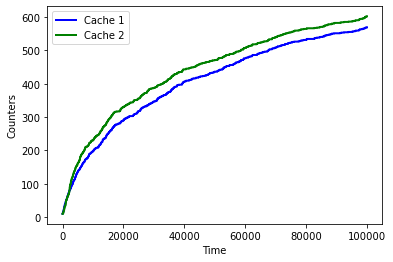

Hit Rate for Combined Cache =  0.03137
Hit Rate for Cache1 =  0.01701
Hit Rate for Cache2 =  0.015595275638612804
Cachehit =  0.01617
Stretch =  0.9838733333333334


In [22]:
totalreq = netdata['req'].shape[0]

params10 = lfulite_tandem_sim(cache_size = 10, req = netdata['req'], prob = netdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params10['regret_all'], Counter = params10['counter_all'], regname="ovnetregllite.eps")
printparam(totalreq, hits = params10['hit_all'], stretch = params10['stretch'], cachehit = params10['cachehit'], c2req=params10['c2req'] )

YouTube Data

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:39<00:00, 1001.04it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


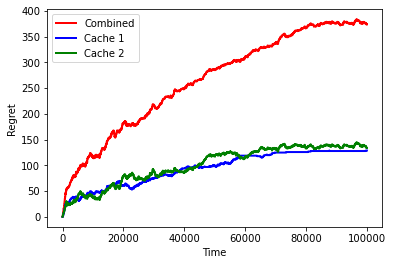

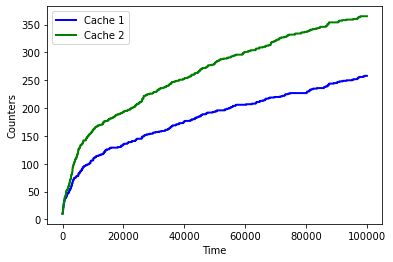

Hit Rate for Combined Cache =  0.04748
Hit Rate for Cache1 =  0.03061
Hit Rate for Cache2 =  0.018547746521008057
Cachehit =  0.024295
Stretch =  0.97397


In [23]:
totalreq = ytdata['req'].shape[0]

params11 = lfulite_tandem_sim(cache_size = 10, req = ytdata['req'], prob = ytdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params11['regret_all'], Counter = params11['counter_all'], regname="ovytregllite.eps")
printparam(totalreq, hits = params11['hit_all'], stretch = params11['stretch'], cachehit = params11['cachehit'],  c2req= params11['c2req'])

Static Zipf Data

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:47<00:00, 2092.15it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


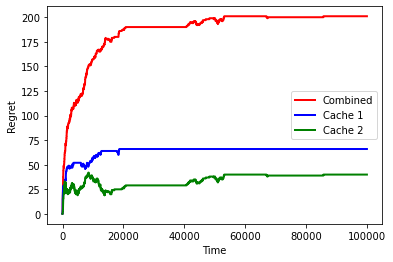

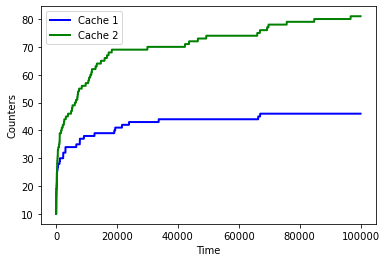

Hit Rate for Combined Cache =  0.28466
Hit Rate for Cache1 =  0.2329
Hit Rate for Cache2 =  0.06871333594055534
Cachehit =  0.142805
Stretch =  0.82748


In [24]:
totalreq = szdata['req'].shape[0]

params12 = lfulite_tandem_sim(cache_size = 10, req = szdata['req'], prob = szdata['prob'], overlap = True)
plotregcount(totalreq, Regret = params12['regret_all'], Counter = params12['counter_all'], regname="ovszregllite.eps")
printparam(totalreq, hits = params12['hit_all'], stretch = params12['stretch'], cachehit = params12['cachehit'],  c2req= params12['c2req'])

Diversity Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


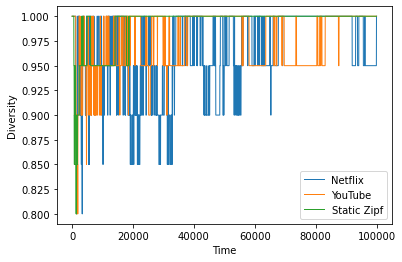

In [25]:
import matplotlib.pyplot as plt

x = list(range(totalreq))
plt.plot(x, params10['diversity'], label='Netflix', linewidth=1)
plt.plot(x, params11['diversity'], label='YouTube', linewidth=1)
plt.plot(x, params12['diversity'], label='Static Zipf', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Diversity')
plt.legend(loc="best")
plt.savefig("../plots/tandem_model/static_data/alldivlfulite.eps")